# Step 0: Input Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils.sys_utils import create_dir

# Constants
ANNOTATIONS_FILEPATH = "./data/ldsi_w21_curated_annotations_v2.json"
UNLABELED_DATA_DIR = "./data/unlabeled/"

OUT_DIR = "./out/"
GENERATED_TOKENS_FOR_EMBEDDINGS_FILEPATH = OUT_DIR + "_generated_tokens_for_embeddings.txt"
EMBEDDINGS_MODEL_FILEPATH = OUT_DIR + "_embeddings_model.bin"

# Create the out directory
create_dir(OUT_DIR)

# Step 1: Dataset Splitting

In [2]:
from src.corpus import Corpus

# Initialize the Corpus
corpus = Corpus(ANNOTATIONS_FILEPATH, UNLABELED_DATA_DIR)
print(corpus)

Log (2022-03-04 13:25:40.421333): Loading the labeled data..
Log (2022-03-04 13:25:40.509886): 540 documents loaded, 141 of which are annotated!
Log (2022-03-04 13:25:40.512596): Loading the unlabeled data..


100%|██████████| 30000/30000 [00:08<00:00, 3727.10it/s]

Log (2022-03-04 13:25:48.749694): 30000 unlabeled documents loaded!
Corpus summary:
Validation set: ['61aea57097ad59b4cfc41361', '61aea57097ad59b4cfc41358', '61aea57097ad59b4cfc4135a', '61aea55e97ad59b4cfc412fb', '61aea55d97ad59b4cfc412bc', '61aea55c97ad59b4cfc412a1', '61aea57497ad59b4cfc413e1', '61aea55e97ad59b4cfc412f0', '61aea57497ad59b4cfc413bd', '61aea57497ad59b4cfc413e8', '61aea55f97ad59b4cfc41307', '61aea55c97ad59b4cfc4129f', '61aea55e97ad59b4cfc412ea', '61aea57497ad59b4cfc413c9']
Test set: ['61aea55d97ad59b4cfc412cd', '61aea55e97ad59b4cfc412da', '61aea57497ad59b4cfc413ea', '61aea57397ad59b4cfc4139c', '61aea57497ad59b4cfc413e0', '61aea57497ad59b4cfc413e7', '61aea57497ad59b4cfc413af', '61aea55f97ad59b4cfc41319', '61aea55c97ad59b4cfc412ac', '61aea57497ad59b4cfc413d1', '61aea55e97ad59b4cfc412df', '61aea55e97ad59b4cfc412ee', '61aea55c97ad59b4cfc41290', '61aea57097ad59b4cfc41367']


# Step 2: Sentence Segmentation

In [3]:
from src.segmentation.spacy_segmenter import SpacySegmenter
from src.segmentation.luima_law_segmenter import LuimaLawSegmenter

# Initialize the segmenters
segmenters = {
    # Step 2.1: Standard segmentation analysis
    "NaiveSpacySegmenter": SpacySegmenter(corpus=corpus),
    # Step 2.2: Improved segmentation analysis
    "ImprovedSpacySegmenter": SpacySegmenter(corpus=corpus, improved=True),
    # Step 2.3: A law-specific sentence segmenter analysis (Luima)
    "LuimaLawSegmenter": LuimaLawSegmenter(corpus=corpus)
}

## Step 2.1: Standard segmentation analysis

In [ ]:
segmenters["NaiveSpacySegmenter"].apply_segmentation(annotated=True, debug=True)

## Step 2.2: Improved segmentation analysis

In [ ]:
segmenters["ImprovedSpacySegmenter"].apply_segmentation(annotated=True, debug=True)

## Step 2.3: A law-specific sentence segmenter analysis (Luima)

In [ ]:
segmenters["LuimaLawSegmenter"].apply_segmentation(annotated=True, debug=True)

### Step 2.3.1: Relaxed error analysis for Luima segmentation by comparing only the start indices (not the end indices) of the splits

In [ ]:
segmenters["LuimaLawSegmenter"].error_analysis_metrics["deep_compare"] = False
segmenters["LuimaLawSegmenter"].apply_segmentation(annotated=True, debug=True)

# Step 3: Preprocessing

In [4]:
from src.tokenizer import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer(segmenters)

# Generate or load sentences and tokens
# sentences, tokens = tokenizer.generate_unlabeled()  # Takes about 4 to 6 hours..
sentences_by_document, tokens_by_document = tokenizer.load_unlabeled()

# Write the tokens to a file to be used as an input to embedding computations
tokenizer.write_tokens_to_file_for_embeddings(sentences_by_document, tokens_by_document,
                                                        filepath=GENERATED_TOKENS_FOR_EMBEDDINGS_FILEPATH)

# Sanity check
assert len(sentences_by_document) == len(tokens_by_document)

print("%d tokens generated from %d sentences" % (
    tokenizer.count_tokens(tokens_by_document),
    tokenizer.count_sentences(sentences_by_document)
))

Log (2022-03-04 13:25:50.632185): Loading the existing sentences generated from the unlabeled corpus..
Log (2022-03-04 13:25:57.588229): Loaded 3360495 sentences generated from the unlabeled corpus!
Log (2022-03-04 13:25:57.588373): Loading the existing tokens generated from the sentence-segmented decisions in the unlabeled corpus..
Log (2022-03-04 13:26:17.886149): Loaded 59660979 tokens generated from the sentence-segmented decisions in the unlabeled corpus!
Log (2022-03-04 13:26:17.886455): Flattening the sentences..
Log (2022-03-04 13:26:17.968381): Randomizing the sentences..
Log (2022-03-04 13:26:21.483947): Writing tokens to a file each line of which consists of a sentence's tokens, separated by a single whitespace..


100%|██████████| 3360495/3360495 [00:05<00:00, 670668.19it/s]


Log (2022-03-04 13:26:28.988312): Tokens generated from 2677682 of 3360495 sentences successfully written to ./out/_generated_tokens_for_embeddings.txt!
59660979 tokens generated from 3360495 sentences


## Step 3.1: Analyze sentences

Number of sentences in documents:
Max = 974
Average = 112


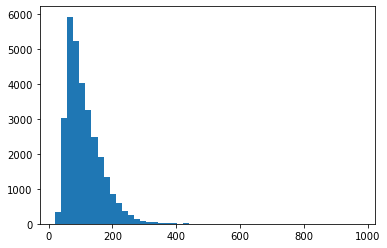

In [5]:
num_sentences_per_document = [len(sentences) for sentences in sentences_by_document.values()]

print("Number of sentences in documents:\nMax = %d\nAverage = %d" % (
    np.max(num_sentences_per_document), 
    np.mean(num_sentences_per_document)
))

plt.hist(num_sentences_per_document, bins=50)
plt.show()

## Step 3.2: Analyze tokens

Number of tokens in sentences:
Max = 20907
Average = 1988


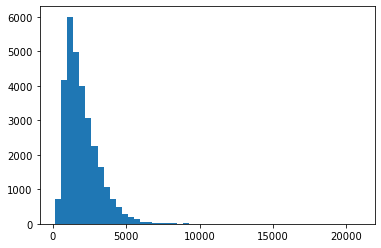

In [6]:
num_tokens_per_sentence = [
    sum([len(sentence_tokens) for sentence_tokens in sentences_with_tokens])
    for sentences_with_tokens in tokens_by_document.values()
]

print("Number of tokens in sentences:\nMax = %d\nAverage = %d" % (
    np.max(num_tokens_per_sentence), 
    np.mean(num_tokens_per_sentence)
))

plt.hist(num_tokens_per_sentence, bins=50)
plt.show()

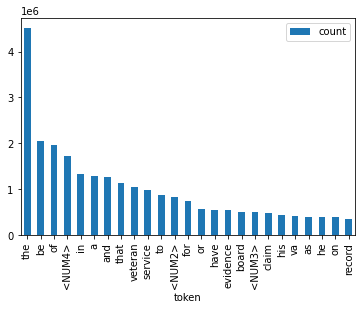

In [7]:
# Calculate token counts
token_counts = {}
for sentences_with_tokens in tokens_by_document.values():
    for sentence_tokens in sentences_with_tokens:
        for token in sentence_tokens:
            if token not in token_counts:
                token_counts[token] = 0
            
            token_counts[token] += 1

# Create token counts dataframe
token_counts_df = pd.DataFrame([{"token": token, "count": count} for (token, count) in token_counts.items()])
token_counts_df = token_counts_df.set_index(["token"])

# Plot token counts dataframe
token_counts_df.sort_values("count", ascending=False)[:25].plot.bar()
plt.show()

## Step 3.1: Free unused memory

In [8]:
del corpus.unlabeled_data
del sentences_by_document, tokens_by_document
del token_counts, token_counts_df

# Step 4: Developing Word Embeddings

## Step 4.1: Train a FastText Embeddings model

In [9]:
from src.embeddings import Embeddings

# Initialize an embeddings model
embeddings = Embeddings(model_filepath=EMBEDDINGS_MODEL_FILEPATH)

# Train the model
# embeddings.train(tokens_filepath=GENERATED_TOKENS_FOR_EMBEDDINGS_FILEPATH)

# Log the results
print("Vocabulary size: %d words and %d labels" % (len(embeddings.model.words), len(embeddings.model.labels)))

Log (2022-03-04 13:26:56.499421): The embeddings model is being loaded..
Log (2022-03-04 13:26:57.485225): The embeddings model is successfully loaded!
Vocabulary size: 23386 words and 23386 labels


In [36]:
"Shape of the embeddings model: (%d, %d)" % (np.shape(embeddings.model.words)[0], embeddings.model.get_dimension())

'Shape of the embeddings model: (23386, 100)'

## Step 4.2: Evaluating Embeddings via Nearest Neighbors

In [37]:
embeddings.get_nearest_neighbors([
    # Words recommended by the Professor
    "veteran", "v.", "argue", "ptsd", "grant", "korea", "holding", "also",
    # Additional words of interest
    "judge", "appear", "board", "evidence", "claim", "connection",
    "vietnam", "decision", "c.f.r", "38", "when"
])

{'veteran': [(0.7084043025970459, 'his'),
  (0.6972131133079529, 'the'),
  (0.6539403796195984, 'he'),
  (0.6335914731025696, 'that'),
  (0.6326770782470703, 'appellant'),
  (0.629713237285614, 'furthermore'),
  (0.6203492283821106, 'have'),
  (0.6140402555465698, 'moreover'),
  (0.603982150554657, 'additionally'),
  (0.5753063559532166, 'lastly')],
 'v.': [(0.9425032734870911, 'vet.'),
  (0.9404009580612183, 'app.'),
  (0.8356177806854248, 'app'),
  (0.8120343089103699, 'brown'),
  (0.8012104630470276, 'nicholson'),
  (0.7757154703140259, '<NUM3>'),
  (0.7656072378158569, 'supra'),
  (0.761705219745636, 'cf'),
  (0.758561909198761, 'principi'),
  (0.7404296398162842, 'cir.')],
 'argue': [(0.7734380960464478, 'assert'),
  (0.7622024416923523, 'contend'),
  (0.6036292314529419, 'aver'),
  (0.5475767850875854, 'agree'),
  (0.5322855710983276, 'dispute'),
  (0.531535267829895, 'believe'),
  (0.5308288931846619, 'ihp'),
  (0.5278782844543457, 'criticize'),
  (0.5201026201248169, 'somehow')

# Step 5: Training Classifiers

In [44]:
from src.feature_generator import FeatureGenerator

X = {"NaiveTFIDFFeaturizer": None, "WordEmbeddingFeaturizer": None}
y = {"NaiveTFIDFFeaturizer": None, "WordEmbeddingFeaturizer": None}

# Create the feature generator
feature_generator = FeatureGenerator(corpus, tokenization_segmenter=segmenters["ImprovedSpacySegmenter"],
                                     embeddings_model=embeddings.model)
feature_generator.vectorize()

# Prints the feature names
print(feature_generator)

Log (2022-03-04 13:45:25.528368): Adding tokens to the train spans..


100%|██████████| 12336/12336 [01:32<00:00, 132.85it/s]


Log (2022-03-04 13:46:58.393040): Tokens successfully added to the train spans..
Log (2022-03-04 13:46:58.393066): Adding tokens to the val spans..


100%|██████████| 1422/1422 [00:10<00:00, 132.55it/s]


Log (2022-03-04 13:47:09.122685): Tokens successfully added to the val spans..
Log (2022-03-04 13:47:09.122726): Adding tokens to the test spans..


100%|██████████| 1591/1591 [00:11<00:00, 134.23it/s]


Log (2022-03-04 13:47:20.977627): Tokens successfully added to the test spans..
Log (2022-03-04 13:47:20.977766): Vectorizing the training data..
Log (2022-03-04 13:48:51.164393): The training data successfully vectorized!


TypeError: __str__ returned non-string (type list)

## Step 5.1: TFIDF Featurization

In [ ]:
X["NaiveTFIDFFeaturizer"], y["NaiveTFIDFFeaturizer"] = feature_generator.create_inputs_and_labels()

## Step 5.2: Word Embedding Featurization

In [ ]:
X["WordEmbeddingFeaturizer"], y["WordEmbeddingFeaturizer"] = create_inputs_and_labels(
    feature_vector_expanded=True)

## Step 5.3: Model Training

In [ ]:
for featurizer_name in X:
    print("%s:" % featurizer_name)

    for dataset_type in X[featurizer_name]:
        print("- The shapes of X_%s and y_%s are (%d, %d) and (%d, %d) respectively." % (
            featurizer_name, dataset_type, dataset_type,
            X[featurizer_name][dataset_type].shape,
            y[featurizer_name][dataset_type].shape
        ))

    print()

# Step 6: Error Analysis